# Analysis playground

## Import necessary libraries / modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from formatting_funcs import sort_date

## Import data and inspect

In [2]:
# Specify dtypes
train_dtypes = {'family':'category'}

stores_df  = pd.read_csv('./data/stores.csv')
train_df = pd.read_csv('./data/train.csv', dtype=train_dtypes, parse_dates=['date'])

for prod in train_df['family'].unique():
    print(prod)

AUTOMOTIVE
BABY CARE
BEAUTY
BEVERAGES
BOOKS
BREAD/BAKERY
CELEBRATION
CLEANING
DAIRY
DELI
EGGS
FROZEN FOODS
GROCERY I
GROCERY II
HARDWARE
HOME AND KITCHEN I
HOME AND KITCHEN II
HOME APPLIANCES
HOME CARE
LADIESWEAR
LAWN AND GARDEN
LINGERIE
LIQUOR,WINE,BEER
MAGAZINES
MEATS
PERSONAL CARE
PET SUPPLIES
PLAYERS AND ELECTRONICS
POULTRY
PREPARED FOODS
PRODUCE
SCHOOL AND OFFICE SUPPLIES
SEAFOOD


## Looking at one product type in one store
We will attack this in the following way:
* Identify and remove trend
* Identify and remove seaons
* Identify and remove cycles
* Additional info (holidays, promotion, oil price? etc) - remove
* Error term?

### Setup

In [3]:
store_num = 1
product = 'GROCERY I'

example_condition = (train_df['store_nbr'] == store_num) & (train_df['family'] == product)
example_sales = sort_date(train_df[example_condition], add_cols=False)

example_sales.drop(['id','store_nbr','family'], axis=1, inplace=True)

print(example_sales)

             sales  onpromotion
date                           
2013-01-01     0.0            0
2013-01-02  2652.0            0
2013-01-03  2121.0            0
2013-01-04  2056.0            0
2013-01-05  2216.0            0
...            ...          ...
2017-08-11  1270.0           24
2017-08-12  1630.0           28
2017-08-13   952.0           19
2017-08-14  2407.0           30
2017-08-15  2508.0           29

[1684 rows x 2 columns]


#### Detrend

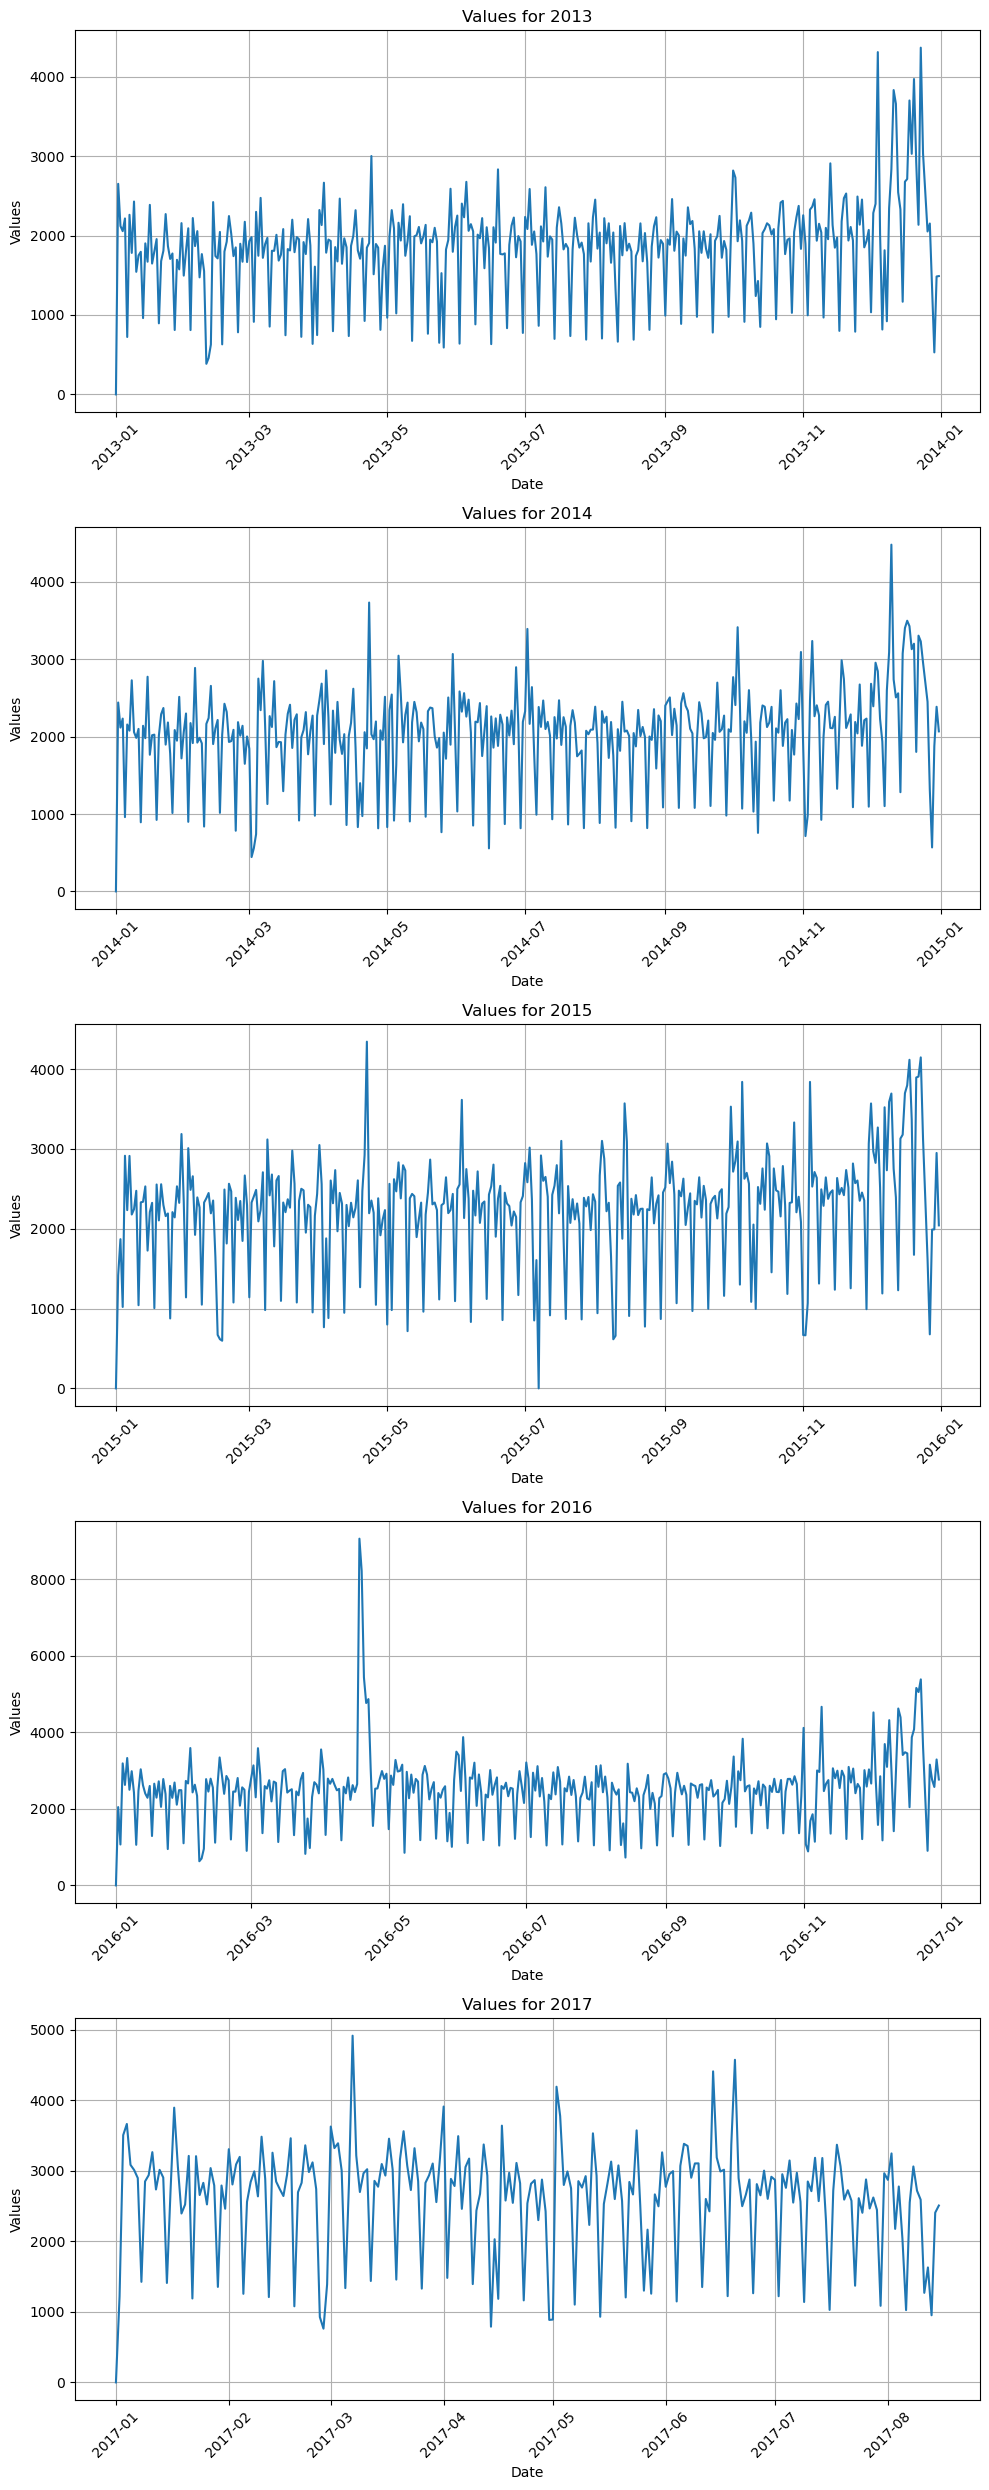

In [4]:
# We will just inspect raw sales each year first

years = example_sales.index.year.unique()

# Create a figure with a subplot for each year
fig, axes = plt.subplots(len(years), 1, figsize=(10, 5 * len(years)), sharex=False)

# Ensure axes is iterable even if there's only one subplot
if len(years) == 1:
    axes = [axes]

# Plot each year's data on a separate subplot
for ax, year in zip(axes, years):
    df_year = example_sales[example_sales.index.year == year]
    ax.plot(df_year.index.to_timestamp(), df_year['sales'])
    ax.set_title(f'Values for {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
example_sales.groupby(lambda x: x.year)['sales'].mean()

date
2013    1856.156593
2014    2038.032967
2015    2235.351648
2016    2518.367123
2017    2614.387665
Name: sales, dtype: float64

<Axes: xlabel='date'>

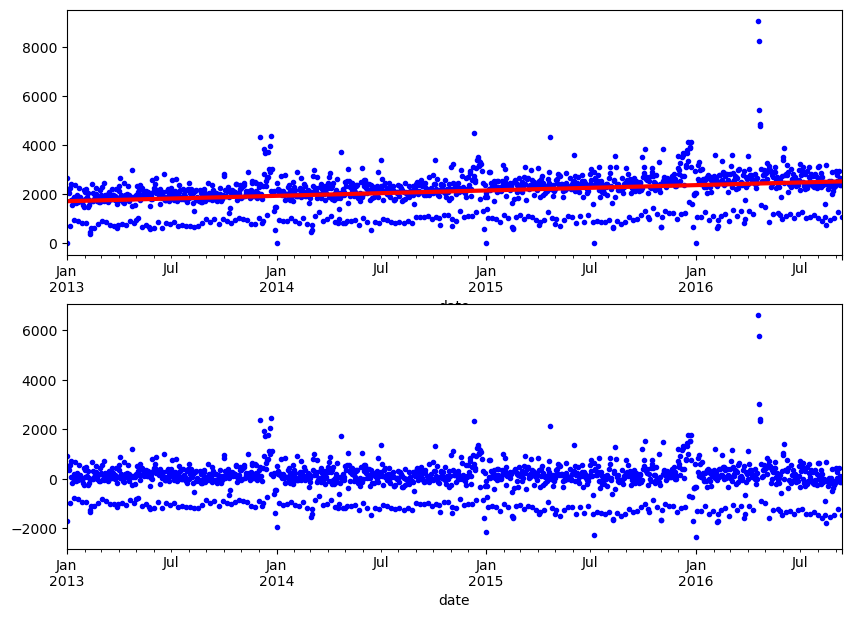

In [6]:
# Find and remove the trend from the sales column

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess


# Set up time features
dp = DeterministicProcess(
    example_sales.index,
    constant=True, 
    order=1, 
    drop=True
)
X = dp.in_sample()

y_sales = example_sales['sales']

X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.2, shuffle=False)

trend_model = LinearRegression(fit_intercept=False)

trend_model.fit(X_train, y_train_sales)

y_lin = pd.Series(trend_model.predict(X_train), index=X_train.index)
y_pred = pd.Series(trend_model.predict(X_test), index=X_test.index)
y_detrend = y_train_sales - y_lin

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)

y_train_sales.plot(ax=ax0, style='.', color='b')
y_lin.plot(ax=ax0, linewidth=3, color='r', label="In-sampe trend")
#_ = y_pred.plot(ax=ax1, linewidth=3, label="Out-sample trend")

y_detrend.plot(ax=ax1, style='.', color='b')

### Seasonal trends?

/home/darren/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/darren/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Seasonal Plot (week/dayofweek)'}, xlabel='dayofweek', ylabel='sales'>

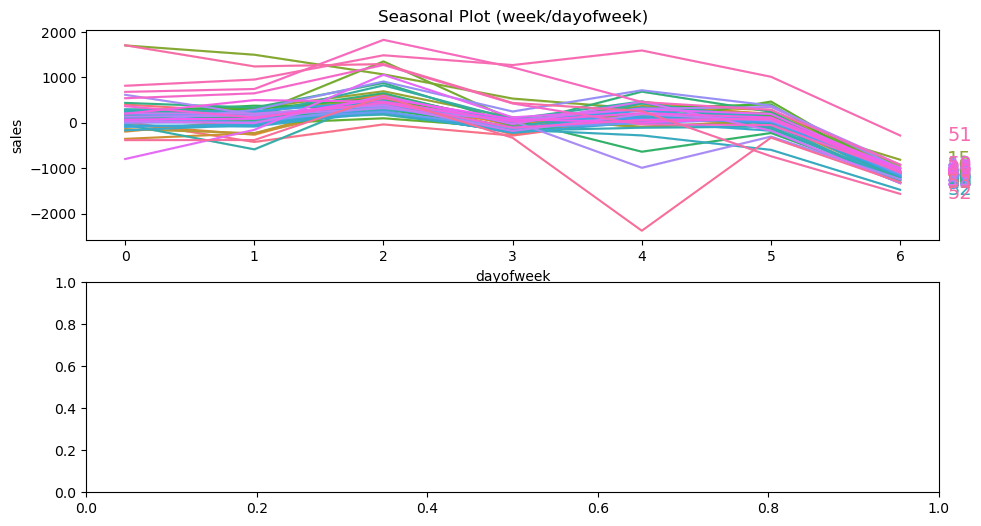

In [7]:
from plotting_routines import seasonal_plot

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))

seasonal_plot(y_detrend, y='sales', period='week', freq='dayofweek', ax=ax0)
#seasonal_plot(example_sales, y='sales', period='year', freq='dayofyear', ax=ax1)
